In [2]:
from astropy import units as u
from poliastro.bodies import Earth, Sun
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter3D
import plotly.io as pio
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
import numpy as np
import pandas as pd
import copy


class satellite:
    def __init__(self, a, ecc, inc, raan, argp, nu, name='UNKNWON SAT'):
        # Initiate orbit object
        self.orb = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu)
        self.name = name    # satellite name
        self.int_clock = 0  # internal clock

    def propagate(self, time):
        self.orb = self.orb.propagate(time * u.s)   # propagate position
        return None

    def skycoord(self):
        satx, saty, satz = self.orb.r    # coordinates (cartesian reference)
        # create coordinate object
        sat_sc = SkyCoord(x=satx, y=saty, z=satz,
                          representation_type='cartesian')
        sat_sc.representation_type = 'spherical'
        sat_sc.ra.wrap_angle = 180 * u.degree  # angles +/-180deg
        sat_sc.dec.wrap_angle = 90 * u.degree  # angles +/-90deg
        return sat_sc


class ground_station:
    def __init__(self, lat, lon, alt=0, name='UNKNOWN GS'):
        """
        altitude in meters
        """
        self.lat = lat  # latitude
        self.lon = lon  # longitude
        self.alt = alt  # altitude in meters

        # Create the coordinate objects
        self.gs = coord.EarthLocation.from_geodetic(lon=lon*u.degree,
                                                    lat=lat*u.degree)
        self.gs_skycoord = SkyCoord(ra=self.gs.lon,   # ra = longitude
                                    dec=self.gs.lat,  # dec = latitude
                                    distance=6371*u.km + alt*u.m)
        self.name = name    # Ground Station name
        self.int_clock = 0  # internal clock

    def skycoord(self):
        return self.gs_skycoord

    def propagate(self, time):
        self.int_clock += time  # update internal clock
        # update longitude due to earth rotation.
        self.lon = (self.lon + time/(24*60*60) * 360) % 360
        # update coordinate object
        self.gs = coord.EarthLocation.from_geodetic(lon=self.lon*u.degree,
                                                    lat=self.lat*u.degree)
        self.gs_skycoord = SkyCoord(ra=self.gs.lon,   # ra = longitude
                                    dec=self.gs.lat,  # dec = latitude
                                    distance=6371*u.km + self.alt*u.m)
        self.gs_skycoord.ra.wrap_angle = 180 * u.degree
        self.gs_skycoord.dec.wrap_angle = 90 * u.degree
        return None

    def transmission(self):
        return None


class sched_transm_gs(ground_station):
    def __init__(self, lat, lon, alt=0, name='UNKNOWN GS'):
        super().__init__(lat, lon, alt, name)
        self.sched_time = 60 * 10   # schedul transm interval in seconds
        self.last_trnsmt = self.int_clock
        self.repeat = 1     # Number of message repeats
        self.repeat_count = 0   # Counter for repeated messages
        self.msg_id = -1     # message ID

    def dgp(self):      # Data Generation Process
        return np.random.randint(0, 25)

    def transmission(self):
        if self.int_clock - self.last_trnsmt > self.sched_time:
            # Run this every sched_time seconds
            self.msg_id += 1
            self.last_trnsmt = self.int_clock
            self.data = self.dgp()
            self.repeat_count = self.repeat
            return self.data, self.msg_id
        elif self.repeat_count > 0:
            # Run this when the repeat counter is positive
            # (i.e. we repeat the last transmission)
            self.repeat_count -= 1
            return self.data, self.msg_id
        else:
            return None, None


In [3]:
N_constellation = 4
sats = list()

a = 6928 * u.km
ecc = 0 * u.one
inc = 97.59 * u.deg
raan = 270 * u.deg
argp = 0 * u.deg
nu = -180 * u.deg

sats = list()
for i in range(N_constellation):
    sats.append(satellite(a, ecc, inc, raan, argp,
                          nu + 360*i/N_constellation * u.deg,
                          name='PICO'+str(i)))

gs = ground_station(45.5, 10.2, 0, 'Brescia 01')

In [4]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(gs.gs.lon.radian, gs.gs.lat.radian)
[ax.scatter(sat.skycoord().ra.radian, sat.skycoord().dec.radian, label=sat.name) for sat in sats ]
# ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
ax.legend()

NameError: name 'plt' is not defined

In [ ]:
t_stp = 60*60  # seconds
sim_steps = 24
for stp in range(sim_steps):
    gs.propagate(t_stp)
    for sat in sats:
        sat.propagate(t_stp)
        link_angl = gs.skycoord().separation(sat.skycoord())
        if link_angl <= 70 * u.degree:
            print(f'connection with satellite {sat.name}')

connection with satellite PICO1
connection with satellite PICO2
connection with satellite PICO3
connection with satellite PICO0
connection with satellite PICO1
connection with satellite PICO2
connection with satellite PICO3
connection with satellite PICO0
connection with satellite PICO1
connection with satellite PICO2
connection with satellite PICO0
connection with satellite PICO3
connection with satellite PICO0
connection with satellite PICO1
connection with satellite PICO2
connection with satellite PICO0
connection with satellite PICO3
connection with satellite PICO1
connection with satellite PICO2
connection with satellite PICO0
connection with satellite PICO3
connection with satellite PICO1
connection with satellite PICO2
connection with satellite PICO3
connection with satellite PICO0
connection with satellite PICO1
connection with satellite PICO2
connection with satellite PICO3
connection with satellite PICO0
connection with satellite PICO1
connection with satellite PICO2
connecti

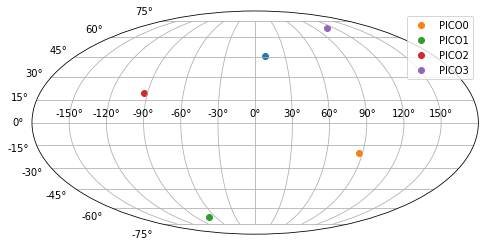

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(gs.gs.lon.radian, gs.gs.lat.radian)
[ax.scatter(sat.skycoord().ra.radian, sat.skycoord().dec.radian, label=sat.name) for sat in sats ]
# ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
ax.legend()

In [ ]:
gs.skycoord()

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, km)
    (10.2, 45.5, 6371.)>

In [10]:
gs.lon


In [13]:
gs = sched_transm_gs(45.5, 10.2, 0, 'Brescia 01')

t_stp = 60  # seconds
sim_steps = 200  # simulation steps
data_row = {'msg_id':-1}
[data_row.update({sat.name: 0}) for sat in sats]
data_lst = list()

for stp in range(sim_steps):
    gs.propagate(t_stp)
    data, id = gs.transmission()
    data_tmp_row = copy.deepcopy(data_row)
    for sat in sats:
        sat.propagate(t_stp)
        link_angl = gs.skycoord().separation(sat.skycoord())
        if link_angl <= 70 * u.degree and data is not None:
            # print(f'Satellite {sat.name} received {data}')
            data_tmp_row.update({'msg_id': id, sat.name: 1})
    if data_tmp_row['msg_id'] != -1:
        data_lst.append(data_tmp_row)


In [15]:
data_lst
df = pd.DataFrame(data_lst)
df

,msg_id,PICO0,PICO1,PICO2,PICO3
0,0,0,1,1,0
1,0,0,1,1,0
2,1,0,1,0,0
3,1,0,1,0,0
4,2,0,1,0,0
5,2,0,1,0,0
6,3,1,0,0,0
7,3,1,0,0,0
8,4,1,0,0,0
9,4,1,0,0,0


In [17]:
ddf = df.groupby('msg_id')

In [24]:
ddf.sum()

,PICO0,PICO1,PICO2,PICO3
msg_id,,,,
0,0,2,2,0
1,0,2,0,0
2,0,2,0,0
3,2,0,0,0
4,2,0,0,0
5,2,0,0,2
6,0,0,0,2
7,0,0,2,2
8,0,0,2,0


In [26]:
sdf = pd.read_pickle('dgp_contacts.pkl')

In [27]:
sdf.describe()

,PICO0,PICO1,PICO2,PICO3
count,909.000000,909.000000,909.000000,909.000000
mean,0.728273,0.733773,0.735974,0.733773
std,0.952555,0.951218,0.954143,0.955838
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.000000,2.000000


In [30]:
sdf.groupby('PICO0').mean()

,PICO1,PICO2,PICO3
PICO0,,,
0,0.785589,1.175747,0.785589
1,1.000000,0.000000,1.000000
2,0.627329,0.000000,0.627329
